In [4]:
#@author: Masayuki Ishimaru

# Gaussian process regression selecting best kernel through cross validation <br>
Reference : <br>
https://datachemeng.com/kernel_design_in_gpr/ <br>
https://upura.hatenablog.com/entry/2018/12/04/224436

In [6]:
# Import library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# GPR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct, ConstantKernel, WhiteKernel

# Cross validation
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
# Load dataset

df = pd.read_csv('glass.csv')
print(df.shape)
df.head()

(214, 11)


,Id number,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type of glass
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [8]:
#　Get column number of start and end of elements

start = df.columns.get_loc('Na')
end   = df.columns.get_loc('Fe') + 1
print('start = ', start)
print('end   = ', end)

start =  2
end   =  10


In [9]:
# Definition of variables

X_composition = df.iloc[:, start:end]
y_density  = df['RI']

In [10]:
print(X_composition.shape)
X_composition.head()

(214, 8)


,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


In [11]:
print(y_density.shape)
y_density.head()

(214,)


0    1.52101
1    1.51761
2    1.51618
3    1.51766
4    1.51742
Name: RI, dtype: float64

# Split train, veridation, and test set

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_composition, y_density, test_size = 0.1, random_state = 1)

X_train_ridx = X_train.reset_index(drop = True)                 # assign new index number for cross-validation
X_test_ridx  = X_test.reset_index(drop = True)
y_train_ridx = y_train.reset_index(drop = True)
y_test  = y_test.reset_index(drop = True)

In [37]:
# scaling

def standardize_dataframe(X, X_base):
    X_scaled = (X - X_base.mean(axis = 0)) / X_base.std(axis = 0)
    
    return X_scaled

def standardize_series(y):
    y_scaled = (y - y.mean()) / y.std()
    
    return y_scaled

In [38]:
X_train = standardize_dataframe(X_train_ridx, X_train_ridx)
X_test  = standardize_dataframe(X_test_ridx, X_train_ridx)
y_train = standardize_series(y_train_ridx)

print(X_train.shape)
X_train.head()

(192, 8)


,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.045685,0.276800,1.225641,-0.526558,0.857981,-1.391522,-0.358855,-0.562001
1,0.605645,0.726295,-0.598569,-0.741406,-0.670585,0.015630,-0.358855,-0.562001
2,0.140459,0.501548,0.090577,-0.848830,0.093698,-0.062114,-0.358855,-0.562001
3,-0.161283,0.529641,-0.537762,0.091128,0.064303,-0.233149,-0.358855,-0.562001
4,-0.098420,0.613921,0.191922,0.265692,0.137791,-0.761802,-0.358855,-0.562001


In [39]:
print(y_train.shape)
y_train.head()

(192,)


0   -1.525416
1    0.361634
2   -0.145840
3   -0.931484
4   -0.690904
Name: RI, dtype: float64

# Train the models

In [40]:
# Definition of Gaussian kernels

n_features = len(X_train.columns)

kernel_dict = {0:ConstantKernel() * DotProduct() + WhiteKernel(),
               1:ConstantKernel() * RBF() + WhiteKernel(),
               2:ConstantKernel() * RBF() + WhiteKernel() + ConstantKernel() * DotProduct(),
               3:ConstantKernel() * RBF(np.ones(n_features)) + WhiteKernel(),
               4:ConstantKernel() * RBF(np.ones(n_features)) + WhiteKernel() + ConstantKernel() * DotProduct(),
               5:ConstantKernel() * Matern(nu=1.5) + WhiteKernel(),
               6:ConstantKernel() * Matern(nu=1.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
               7:ConstantKernel() * Matern(nu=0.5) + WhiteKernel(),
               8:ConstantKernel() * Matern(nu=0.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
               9:ConstantKernel() * Matern(nu=2.5) + WhiteKernel(),
               10:ConstantKernel() * Matern(nu=2.5) + WhiteKernel() + ConstantKernel() * DotProduct()}

In [41]:
def Make_Model(X, y):
    with np.errstate(invalid = 'ignore'):
        
        score_mean_SS = []
        split_num = 5
        
        for i in kernel_dict.keys():
            kern = kernel_dict[i]
            cv_SS = ShuffleSplit(n_splits = split_num, random_state = 1, test_size = 0.2, train_size = None)
            score_temp_SS = []

            for train_index, test_index in cv_SS.split(X):
                X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]
                gaussr = GaussianProcessRegressor(kernel = kern).fit(X_train, y_train)

                y_pred = gaussr.predict(X_test)
                R2_gauss = r2_score(y_test, y_pred)
                score_temp_SS.append(R2_gauss)
            score_mean_SS.append(np.mean(score_temp_SS))
            print('kernel = ', i, '  R2 mean = {:.4}'.format(np.mean(score_temp_SS)))
            
    plt.bar(kernel_dict.keys(), score_mean_SS)
    plt.title('Cross validation R2 comparison by kernel')
    plt.xlabel('Gaussian kernel index number')
    plt.ylabel('R2')
    plt.show()
    
    best_kernel_index = score_mean_SS.index(np.max(score_mean_SS))
    
    return best_kernel_index

In [42]:
import warnings
warnings.filterwarnings('ignore')

kernel =  0   R2 mean = 0.776
kernel =  1   R2 mean = 0.7569
kernel =  2   R2 mean = 0.7619
kernel =  3   R2 mean = 0.6642
kernel =  4   R2 mean = 0.7526
kernel =  5   R2 mean = 0.7565
kernel =  6   R2 mean = 0.7659
kernel =  7   R2 mean = 0.7197
kernel =  8   R2 mean = 0.7729
kernel =  9   R2 mean = 0.7578
kernel =  10   R2 mean = 0.7639


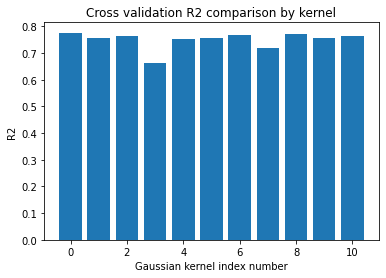

Best kernel index (highest R2) =  0


In [43]:
best_kernel_index = Make_Model(X_train, y_train)
print('Best kernel index (highest R2) = ', best_kernel_index)

In [44]:
# Make best kernel model within training and velidation sets

with np.errstate(invalid = 'ignore'):
    best_gaussr = GaussianProcessRegressor(kernel = kernel_dict[best_kernel_index]).fit(X_train, y_train)

R2 =   0.985


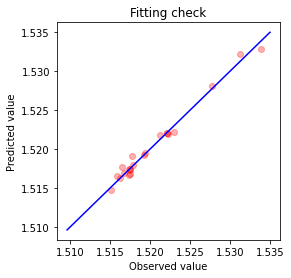

In [46]:
# test the model

y_pred = best_gaussr.predict(X_test) * y_train_ridx.std() + y_train_ridx.mean()

print('R2 = ', ' {:.4}'.format(r2_score(y_test, y_pred)))

plt.figure(figsize = [4, 4])
slp_1_begin = 0.999 * y_train_ridx.min()
slp_1_end   = 1.005 * y_train_ridx.max()

plt.scatter(y_test, y_pred, c = 'r', alpha = 0.3)
plt.plot([slp_1_begin, slp_1_end], [slp_1_begin, slp_1_end], c = 'b')
plt.title('Fitting check')
plt.xlabel('Observed value')
plt.ylabel('Predicted value')
plt.show()

In [47]:
# looks good then finalize the model using all data

X_train_final = standardize_dataframe(X_composition, X_composition)
y_train_final = standardize_series(y_density)

with np.errstate(invalid = 'ignore'):
    best_gaussr_final = GaussianProcessRegressor(kernel = kernel_dict[best_kernel_index]).fit(X_train_final, y_train_final)

R2 =   0.8925


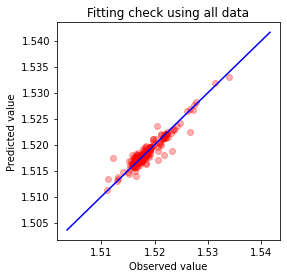

In [50]:
y_pred = best_gaussr_final.predict(X_train_final) * y_density.std() + y_density.mean()

print('R2 = ', ' {:.4}'.format(r2_score(y_density, y_pred)))

plt.figure(figsize = [4, 4])
slp_1_begin = 0.995 * y_density.min()
slp_1_end   = 1.005 * y_density.max()

plt.scatter(y_density, y_pred, c = 'r', alpha = 0.3)
plt.plot([slp_1_begin, slp_1_end], [slp_1_begin, slp_1_end], c = 'b')
plt.title('Fitting check using all data')
plt.xlabel('Observed value')
plt.ylabel('Predicted value')
plt.show()

In [52]:
# Save the model, mean, and standard deviation

import pickle
with open('best_gaussr_RI.pickle', mode='wb') as f:
    pickle.dump(best_gaussr_final, f)
    
y_density_mean_std = np.array([y_density.mean(), y_density.std()])
print(y_density_mean_std)

np.save('density_mean_std_GPR', y_density_mean_std)

[1.51836542 0.00303686]
